# Luca Miglior - Assignment 2 - Track 3


## Introduction
For this assignment purposes, i have implemented a simple Restricted boltzmann machine model.
The training algorithm is mainly based on on-line contrastive divergence learning. In particular, CD-1 learning has been implemented, meaning that only one step of the more general CD-K algorithm will be computed, for each sample, to estimate the gradient of the log likelihood w.r.t. to model's weights.

As presented during the course, CD-1 gradient estimation implementation is based on the following equation: 
$$ \frac{\partial \mathcal{L}}{\partial{M_{ij}}} = \langle v_ih_j \rangle_0 - \langle v_ih_j \rangle_1 = wake - dream $$
where the first term of the second member has been named the `wake` part of the gradient, because it is computed on the actual data and the second term is the `dream` part, based on the reconstruction. The training algorithm follows the schema presented by Hinton's in [2]. Main algorithm's steps are the following:

1. Randomly initialize weights and biases for the model.
2. Then, for `epochs` epochs, for `data in dataset`
3. Compute $P(h|v) = \sigma(Mv + b_h)$
4. Compute $wake = P(h|v)v $
5. Now, sample the binary hidden states based on $P(h|v)$
6. Compute probabilities of the reconstruction as $P(v = 1|h) = \sigma(Mh + b_v)$ and sample reconstructed states on them
7. Get again the probability distribution of the hidden states given the reconstruction and compute the dream part
8. compute $\Delta w = wake - dream$ and biases
9. finally update model's parameters according to a user-defined parameter `learning_rate`
 
Full code can be found in the file `rbm.py` with further details.

## First part, import dataset and preparing it by binarizing data.

In [1]:
from rbm import RestrictedBoltzmannMachine as RBM
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.datasets import mnist


# load the dataset
# https://keras.io/api/datasets/mnist/ (same provided on e-learning)

dataset = mnist.load_data()
X_train, y_train = dataset[0]
X_test, y_test = dataset[1]

# binarize the dataset
X_train = (X_train > 0).astype(int)
X_test = (X_test > 0).astype(int)

# flatten the dataset
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

2023-04-11 16:08:43.174809: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Some words on reconstruction metrics
We have to compute some metrics, in order to assess our model's performance. For this task, i decided to exploit the basic accuracy and recall definitions, as well as the structural similarity metrics. In particular, structural similarity is well defined in [1].

Accuracy may not be the most suitable metric for this problem: in fact, given an image and its reconstruction, this would be a really imbalanced classification task, and I expect to find decent accuracy values even for poor reconstructions, since the vast majority of the pixels are black (negative class). For this reason, recall will also be taken in consideration, to assess reconstruction quality towards false positives.
Moreover, in this perspective, structural similarity may be a more accurate metric. 

The following cell defines a method that given an instance of my brand new RBM class will reuturn a triple with these metrics, averaged on all the samples in the provided test set. 

Metrics implementation was taken from `sklearn` and `skimage` libraries.

In [2]:
from sklearn.metrics import accuracy_score, recall_score
from skimage.metrics import structural_similarity

def evaluate_rbm(rbm, X_test):
    """
    Evaluate performance of the given RBM.
    :param rbm: an instance of RestrictedBoltzmannMachine class
    :X_test: test data
    :return: triple <model accuracy, model recall, model structural similarity>
    """
    accuracy = []
    recall = []
    ssims = []

    for i in range(len(X_test)):
        test_sample = X_test[i]
        reconstructed = rbm.reconstruct(test_sample)
     
        # sampling reconstructions
        reconstructed = reconstructed > np.random.rand(len(reconstructed))
        reconstructed = reconstructed.astype('int64')
        # computing metrics
        accuracy.append(accuracy_score(test_sample, reconstructed))
        recall.append(recall_score(test_sample, reconstructed))
        ssims.append(structural_similarity(test_sample, reconstructed, data_range=1))

        
    return np.mean(accuracy), np.mean(recall), np.mean(ssims)

## Now, we have to train one RBM for each digit present in the MNIST dataset.

In [4]:
# train one rbm for each digit in the train set
rbms = []
for i in range(10):
    print("Training RBM for digit", i)
    rbm = RBM(X_train.shape[1], 100)
    rbm.train(X_train[y_train == i], 10, 0.01)
    rbms.append(rbm)


Training RBM for digit 0


KeyboardInterrupt: 

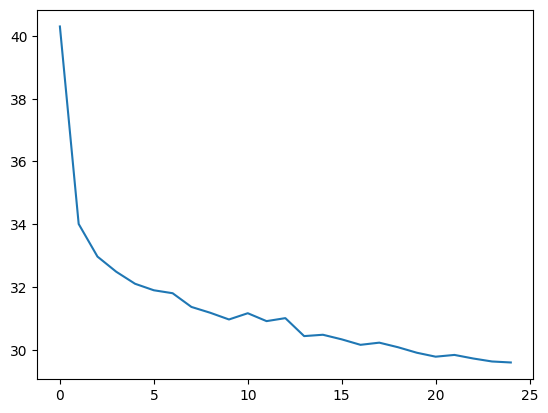

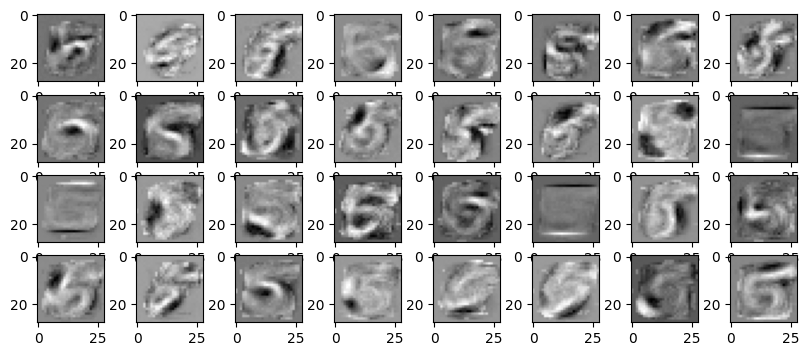

In [52]:
rbm = RBM(784, 64)

rbm.train(X_train[y_train == 5][:5000], epochs=25, learning_rate=0.1)
plt.plot(rbm.errors)

fig, axes = plt.subplots(4, 8, figsize=(10, 4))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(rbm.weights[i].reshape(28, 28), cmap='gray')


In [53]:
# evaluate the rbm
acc, rec, ssim = evaluate_rbm(rbm, X_test[y_test == 5])
print(f"Accuracy: {acc:.2f}, Recall {rec:.2f}, Structural similarity: {ssim:.2f}")


Accuracy: 0.93, Recall 0.83, Structural similarity: 0.80


ssim: 0.874233


Text(0.5, 1.0, 'Reconstructed')

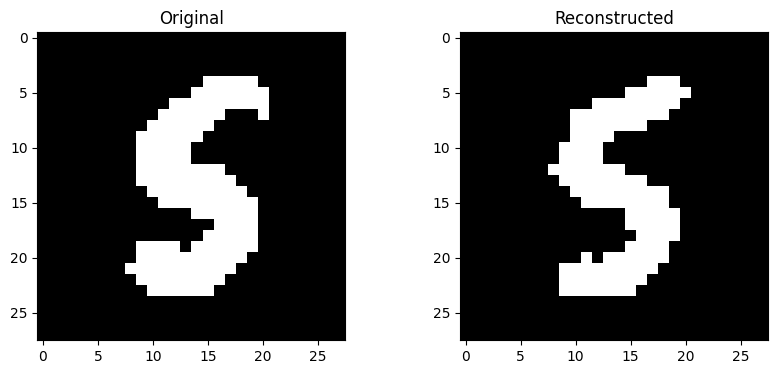

In [51]:
# print the original image and the reconstructed one
test_sample = X_test[y_test == 5][np.random.randint(0, X_test[y_test == 2].shape[0])]
reconstructed = rbm.reconstruct(test_sample)
reconstructed[reconstructed > 0.5] = 1
reconstructed[reconstructed < 0.5] = 0

ssim = structural_similarity(reconstructed, test_sample, data_range=1)
print(f'ssim: {ssim:2f}')

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(test_sample.reshape(28, 28), cmap='gray')
axes[1].imshow(reconstructed.reshape(28, 28), cmap='gray')
# add labels 
axes[0].set_title('Original')
axes[1].set_title('Reconstructed')

## References
Course slides

[[1] Wang et al., Image Quality Assessment: From Error Visibility to Structural Similarity](http://www.cns.nyu.edu/pub/eero/wang03-reprint.pdf)

[[2] G. Hinton, A Practical Guide to Training Restricted Boltzmann Machines](https://www.cs.toronto.edu/~hinton/absps/guideTR.pdf)

[[3] A. Fischer et al., Training restricted Boltzmann machines: An introduction](https://www.sciencedirect.com/science/article/abs/pii/S0031320313002495)

